This script is used for RT analysis for the stimulus-based condition in section:
"Rule- and stimulus-based biases had different effects on choices and RTs"

In [1]:
#clear memory
rm(list=ls())

#This implements simple RT analyses of pretone data
#choice analyses are now handled by fits of psychometric function in Matlab


## loading data/libraries ##

#load libraries
library(lme4)
#library(plyr)
library(dplyr)
#library(tidyr)
library(car)
library(lmerTest)
library(emmeans)
#library(afex)
emm_options(lmerTest.limit = 22676)
library(lattice)
library(ggplot2)

se <- function(x) sqrt(var(x) / length(x))

switch(Sys.info()[['sysname']],
       Windows = PROJECT_DIR <- paste0('C:/Users/',Sys.getenv('USERNAME'),
                                       '/Dropbox/Goldlab/AuditoryPriors/'),
       Darwin = PROJECT_DIR <- '~/Dropbox/Goldlab/AuditoryPriors/'
)

setwd(paste0(PROJECT_DIR,'data processing'))


DATA_DIR = './data/'
DATA_FILE ='pretoneOnly_for_R_29-May-2020.csv'

pt_df <- read.table(paste0(DATA_DIR,DATA_FILE),sep=',', header=TRUE, 
                    stringsAsFactors=FALSE,na.strings = 'NaN')

#get rid of 0 pretones trials and missing trials in case this wasn't already done
pt_df <- arrange(subset(pt_df,pretoneLength > 0),subject,trialID)

#remove missing data
pt_df <- subset(pt_df,!is.na(choice01) & !is.na(RT))

Loading required package: Matrix

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'car' was built under R version 4.0.4"
Loading required package: carData

Registered S3 methods overwritten by 'car':
  method                          from
  influence.merMod                lme4
  cooks.distance.influence.merMod lme4
  dfbeta.influence.merMod         lme4
  dfbetas.influence.merMod        lme4


Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode


Warning message:
"package 'lmerTest' was built under R version 4.0.4"

Attaching package: 'lmerTest'


The following object is masked from 'package:lme4':

    lmer


The following object is masked from 'package:stats':

 

In [2]:
#set up variables
pt_df$aSNR <- abs(pt_df$SNR)

#set up congruent proxy variable
# WARNING: THIS IS CONGRUENT WITH STIM! Doesn't matter if only analyzing correct RT but beware!!!
pt_df$congruent <- NA
attach(pt_df)  
pt_df$congruent[(isH==1 & pretoneSeqisH_1==1 & pretoneSeqisH_2==1) | 
           (isH==0 & pretoneSeqisH_1==0 & pretoneSeqisH_2==0)] <- 3
pt_df$congruent[(isH==1 & pretoneSeqisH_1==1 & pretoneSeqisH_2==0) | 
        (isH==0 & pretoneSeqisH_1==0 & pretoneSeqisH_2==1)] <-  2
pt_df$congruent[(isH==1 & pretoneSeqisH_1==0 & pretoneSeqisH_2==1) | 
        (isH==0 & pretoneSeqisH_1==1 & pretoneSeqisH_2==0)] <- 1
pt_df$congruent[(isH==0 & pretoneSeqisH_1==1 & pretoneSeqisH_2==1) | 
                  (isH==1 & pretoneSeqisH_1==0 & pretoneSeqisH_2==0)] <- 0
detach(pt_df)
#very minor gut check
if (any(is.na(pt_df$congruent))) {
  warning('Congruent conditions improperly assigned!')
}
con_check <- arrange(unique(pt_df[,c('congruent','isH','pretoneSeqisH_1','pretoneSeqisH_2')]),
                     congruent,isH)
con_check

## Correct RT only
pt_dfc <- subset(pt_df,success==1)


## now compute medians for analysis
pt_dfc.med <- summarise(group_by(pt_dfc,subject,aSNR,congruent,isH,pretoneSeqisH_1,pretoneSeqisH_2),
                        RT=median(RT))

#set up variables
pt_dfc.med$zaSNR <- scale(pt_dfc.med$aSNR)

pt_dfc.med$congruent.fs <- factor(pt_dfc.med$congruent,levels=c(3,2,1,0),
                                  labels=c("CC","CI","IC","II"))
contrasts(pt_dfc.med$congruent.fs) <- contr.sum(4)
contrasts(pt_dfc.med$congruent.fs)

congruent,isH,pretoneSeqisH_1,pretoneSeqisH_2
<dbl>,<int>,<int>,<int>
0,0,1,1
0,1,0,0
1,0,1,0
1,1,0,1
2,0,0,1
2,1,1,0
3,0,0,0
3,1,1,1


`summarise()` regrouping output by 'subject', 'aSNR', 'congruent', 'isH', 'pretoneSeqisH_1' (override with `.groups` argument)



CC,1,0,0
CI,0,1,0
IC,0,0,1
II,-1,-1,-1


## Congruency model

In [3]:
pt_dfc.med[,c('congruent.fs1','congruent.fs2','congruent.fs3')] <- 
  model.matrix(~1+pt_dfc.med$congruent.fs,pt_dfc.med)[,2:4]
pt_dfc.med[,c('zaSNR_congruent.fs1','zaSNR_congruent.fs2','zaSNR_congruent.fs3')] <- 
  pt_dfc.med[,c('congruent.fs1','congruent.fs2','congruent.fs3')] * pt_dfc.med$zaSNR

In [4]:
#first lets do RT model and see where we get
rtccon.lm.0 <- lmer(RT~zaSNR*congruent.fs + (1+zaSNR*congruent.fs|subject), 
                 data=pt_dfc.med, 
                 control=lmerControl(optimizer="bobyqa",optCtrl=list(maxfun=2e5)))

boundary (singular) fit: see ?isSingular



In [5]:
#now iteratively reduce model until convergence
rtccon.lm.0nc <- lmer(RT~zaSNR*congruent.fs + 
                     (1+zaSNR + congruent.fs1 + congruent.fs2 + congruent.fs3 + 
                        zaSNR_congruent.fs1 + zaSNR_congruent.fs2 + zaSNR_congruent.fs3||subject), 
                   data=pt_dfc.med, 
                   control=lmerControl(optimizer="bobyqa",optCtrl=list(maxfun=2e5)))

#check for which rfx have zero variance
summary(rtccon.lm.0nc)$varcor

boundary (singular) fit: see ?isSingular



 Groups    Name                Std.Dev.
 subject   (Intercept)         137.412 
 subject.1 zaSNR                44.077 
 subject.2 congruent.fs1        27.992 
 subject.3 congruent.fs2        34.246 
 subject.4 congruent.fs3        26.549 
 subject.5 zaSNR_congruent.fs1   0.000 
 subject.6 zaSNR_congruent.fs2  10.864 
 subject.7 zaSNR_congruent.fs3   0.000 
 Residual                      112.720 

In [6]:
rtccon.lm.1nc <- lmer(RT~zaSNR*congruent.fs + 
                        (1+zaSNR + congruent.fs1 + congruent.fs2 + congruent.fs3 + 
                           zaSNR_congruent.fs2 + zaSNR_congruent.fs3||subject), 
                      data=pt_dfc.med, 
                      control=lmerControl(optimizer="bobyqa",optCtrl=list(maxfun=2e5)))

boundary (singular) fit: see ?isSingular



In [7]:
#FINAL

#FINAL MODEL
rtccon.lm.2nc <- lmer(RT~zaSNR*congruent.fs + 
                        (1+zaSNR + congruent.fs1 + congruent.fs2 + congruent.fs3 + 
                           zaSNR_congruent.fs2||subject), 
                      data=pt_dfc.med, 
                      control=lmerControl(optimizer="bobyqa",optCtrl=list(maxfun=2e5)))

#fyi: reintro corr doesn't converge...makes sense not enough data

In [8]:
#FINAL

Anova(rtccon.lm.2nc,test.statistic = "F",type="III")

,F,Df,Df.res,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1634.20140,1,44.00235,1.955601e-36
zaSNR,56.66475,1,44.00679,1.939626e-09
congruent.fs,27.75822,3,74.01951,3.909450e-12
zaSNR:congruent.fs,11.58447,3,197.17386,5.012965e-07


In [9]:
#FINAL

#consistent pretones speed RT compared to inconsistent
rtccon.lm.2nc.emm.con <-  emmeans(rtccon.lm.2nc,specs = ~congruent.fs)
contrast(rtccon.lm.2nc.emm.con,list("consistent vs. mixed"=c(-1/2,1/2,1/2,-1/2)))
summary(contrast(rtccon.lm.2nc.emm.con,list("consistent vs. mixed"=c(-1/2,1/2,1/2,-1/2))))

NOTE: Results may be misleading due to involvement in interactions



 contrast             estimate   SE   df t.ratio p.value
 consistent vs. mixed     68.8 8.87 72.1 7.755   <.0001 

Degrees-of-freedom method: kenward-roger 

,contrast,estimate,SE,df,t.ratio,p.value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,consistent vs. mixed,68.8255,8.874911,72.06883,7.755064,4.366957e-11


In [10]:
#FINAL

#now we can ask about the end points 
rtccon.lm.2nc.emm <- emmeans(rtccon.lm.2nc,specs = ~zaSNR*congruent.fs,cov.reduce=range)#,at=list(zaSNR=zaSNR[c(1,4)]))
#pairs(rtccon.lm.2nc.emm,adjust="none")
rtccon.lm.2nc.emm.pairs <- contrast(rtccon.lm.2nc.emm,list("low SNR CC-II"=c(1,0,0,0,0,0,-1,0),
                                "high SNR CC-II"=c(0,1,0,0,0,0,0,-1),
                                "low SNR CI-IC"=c(0,0,1,0,-1,0,0,0),
                                "high SNR CI-IC"=c(0,0,0,1,0,-1,0,0)))
rtccon.lm.2nc.emm.pairs
pairs(rtccon.lm.2nc.emm.pairs,adjust="none")[c(1,6)]
pairs(rtccon.lm.2nc.emm.pairs,adjust="holm")[c(1,6)]
summary(pairs(rtccon.lm.2nc.emm.pairs,adjust="holm")[c(1,6)])

 contrast       estimate   SE    df t.ratio p.value
 low SNR CC-II    -45.53 15.8  96.3 -2.883  0.0049 
 high SNR CC-II    66.72 19.5 202.5  3.421  0.0008 
 low SNR CI-IC    -57.89 13.8 343.5 -4.209  <.0001 
 high SNR CI-IC     7.67 17.8 537.8  0.431  0.6670 

Degrees-of-freedom method: kenward-roger 

 contrast                           estimate   SE  df t.ratio p.value
 (low SNR CC-II) - (high SNR CC-II)   -112.3 22.2 442 -5.061  <.0001 
 (low SNR CI-IC) - (high SNR CI-IC)    -65.6 22.5 459 -2.908  0.0038 

Degrees-of-freedom method: kenward-roger 

 contrast                           estimate   SE  df t.ratio p.value
 (low SNR CC-II) - (high SNR CC-II)   -112.3 22.2 442 -5.061  <.0001 
 (low SNR CI-IC) - (high SNR CI-IC)    -65.6 22.5 459 -2.908  0.0038 

Degrees-of-freedom method: kenward-roger 
P value adjustment: holm method for 2 tests 

,contrast,estimate,SE,df,t.ratio,p.value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,(low SNR CC-II) - (high SNR CC-II),-112.25923,22.18114,442.1637,-5.061022,1.225629e-06
6,(low SNR CI-IC) - (high SNR CI-IC),-65.55356,22.54319,458.6292,-2.907910,3.815036e-03


### generate predictions for plotting

In [12]:
#FINAL

pt_dfc.med$RT_pred <- predict(rtccon.lm.2nc)

#create ptC var for plotting
pt_dfc$ptC1 <- ifelse(pt_dfc$pretoneSeqisH_1==1,'H','L')
pt_dfc$ptC2 <- ifelse(pt_dfc$pretoneSeqisH_2==1,'H','L')
pt_dfc$ptC <- paste0(pt_dfc$ptC1,pt_dfc$ptC2)

head(pt_dfc[,c('ptC1','ptC2','pretoneSeq','ptC')])

,ptC1,ptC2,pretoneSeq,ptC
,<chr>,<chr>,<chr>,<chr>
1,L,L,LLLLLLLLLX,LL
3,L,L,LLHLLLX,LL
4,H,L,LHX,HL
5,L,L,LLX,LL
6,H,H,HHX,HH
8,L,H,LHHHHLX,LH


In [13]:
#FINAL

#plot against medians
pt_dfc.med$ptC1 <- ifelse(pt_dfc.med$pretoneSeqisH_1==1,'H','L')
pt_dfc.med$ptC2 <- ifelse(pt_dfc.med$pretoneSeqisH_2==1,'H','L')
pt_dfc.med$ptC <- paste0(pt_dfc.med$ptC1,pt_dfc.med$ptC2)

pred_ave.med_all <- summarise(group_by(pt_dfc.med,aSNR,isH,ptC),RT_sem=se(RT),RT=mean(RT),RT_pred=mean(RT_pred))
pred_ave.med_all$SNR <- pred_ave.med_all$aSNR *(pred_ave.med_all$isH*2-1)

`summarise()` regrouping output by 'aSNR', 'isH' (override with `.groups` argument)



In [14]:
#output for matlab plotting
if (F) {
    write.csv(pred_ave.med_all,paste0('./pretone_RT_pred_',Sys.Date(),'.csv'),row.names=F)
}

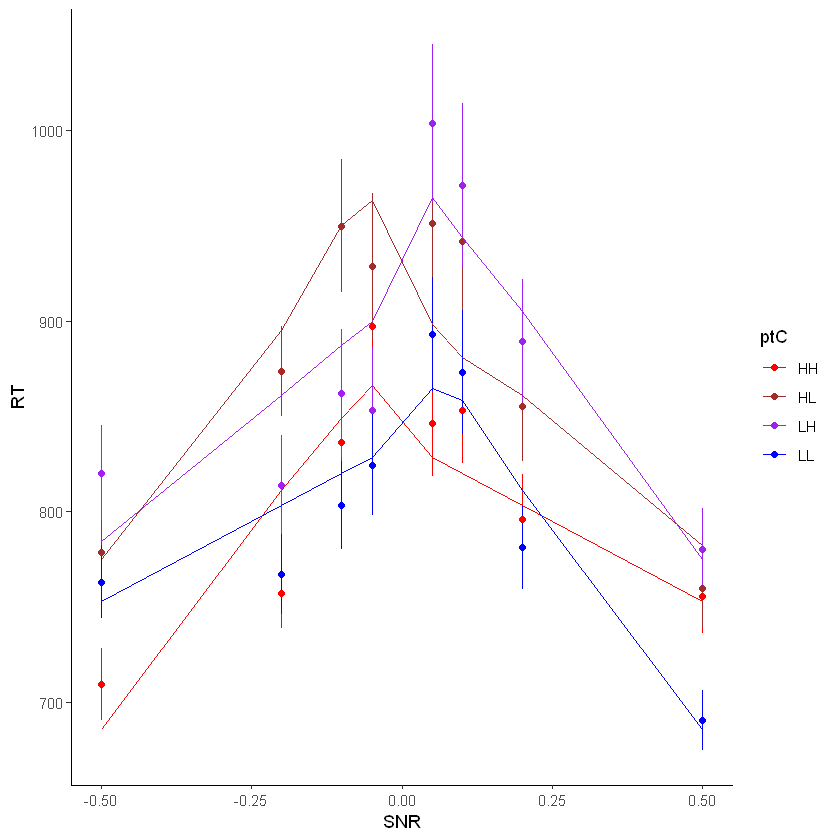

In [15]:
ggplot(pred_ave.med_all, aes(x=SNR, y=RT, colour=ptC)) + 
    geom_errorbar(aes(ymin=RT-RT_sem, ymax=RT+RT_sem), width=0) +
    geom_point() +
    geom_line(aes(x=SNR, y=RT_pred, colour=ptC)) +
    scale_color_manual(values=c("red", "brown", "purple", "blue")) +
    theme_classic()